<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/csivava2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Csivava vagy muffin?

Számos kép kering az interneten, melyen az ember is nehezen tud megkülönböztetni egy csivavát egy áfonyás maffintól. Nézzük meg, hogy a konvolúciós neurális hálózat hogyan boldogul ezzel a feladattal.

Sok csivava és muffin képet összegyűjtöttünk az internetről.

A kép letöltése.

In [ ]:
%cd /content
%mkdir chihu
%mkdir muff

/content


In [ ]:
!wget -q -O cs.zip https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/cs.zip?raw=true
!wget -q -O mu.zip https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/mu.zip?raw=true

In [ ]:
!unzip -nq cs.zip -d chihu
!unzip -nq mu.zip -d muff
!ls -l chihu | wc -l
!ls -l muff | wc -l

162
210


##Képek előkészítése

A 100x100 pixeles, csivava illetve muffin képet egy-egy könyvtárba helyeztük el. Töltsük be a képeket és méretezzük át (opcionális).

In [ ]:
from glob import glob
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

In [ ]:
labels = ["csivava", "muffin"]  # cimke nevek, 0-csivava, 1-maffin)
num_classes = len(labels)
# fájlok száma
num_ch = len(glob('chihu/*.jpg'))
num_mu = len(glob('muff/*.jpg'))
num_all = num_ch + num_mu
print(f"Képek száma: {num_all}, {num_ch} csivava és {num_mu} muffin")
# címkék létrehozása
lab = np.r_[np.zeros(num_ch), np.ones(num_mu)]

Képek száma: 318, 135 csivava és 183 muffin


In [ ]:
image_size = 64                 # a kis képek mérete (négyzetes), pixel
# tömbök létrehozása a bemenő adatoknak és a címkéknek
X = np.zeros((num_all, image_size, image_size, 3, 1), dtype='float32')
y = lab.flatten()
# kis képek létrehozása
k = 0
for name in glob('chihu/*.jpg'):
    img = imread(name)
    # reduce resolution
    X[k] = np.expand_dims(resize(img, (image_size, image_size, 3)), -1)
    k += 1
for name in glob('muff/*.jpg'):
    img = imread(name)
    # reduce resolution
    X[k] = np.expand_dims(resize(img, (image_size, image_size, 3)), -1)
    k += 1

Az előkészítés végén ellenőrizzünk véletlenszerűen néhány képet és címkét!

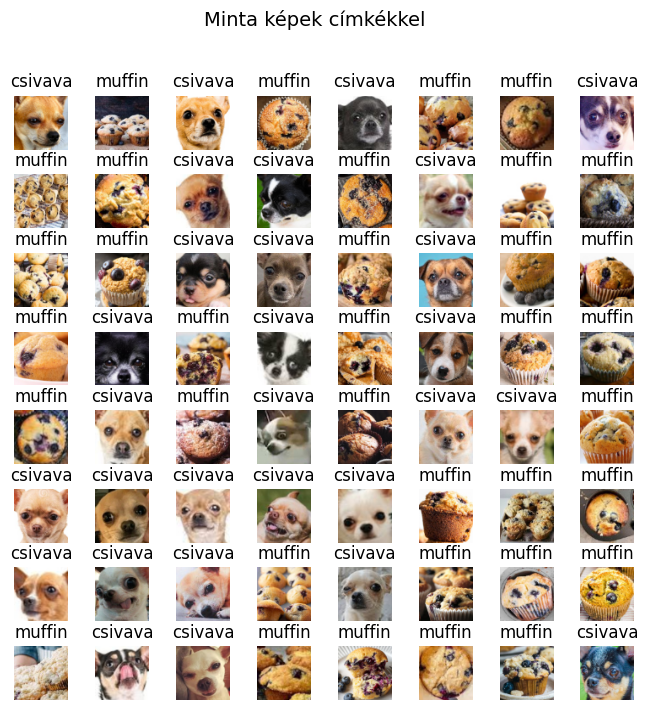

In [ ]:
sample_rows = 8
sample_cols = 8
sample_num = sample_rows * sample_cols
fig, ax = plt.subplots(sample_rows, sample_cols, figsize=(sample_cols, sample_rows))
fig.suptitle('Minta képek címkékkel', fontsize=14)
lst = list(range(num_all))
shuffle(lst)
ax = ax.ravel()
for i in range(sample_num):
    ax[i].imshow(X[lst[i],:,:,:,0])
    ax[i].set_title(labels[int(y[lst[i]])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

##Tanítás

A tanítás soran a felcímkézett képeket tanító (80%) és teszt (20%) részre bontjuk szét. Emellett előkészítjük a Keras használatához.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.utils import to_categorical
from keras.metrics import binary_accuracy
from keras.callbacks import EarlyStopping

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
y_orig_train = y_train.copy()
y_train = to_categorical(y_train, num_classes)      # címkék szükséges átalakítása Kerashoz
y_orig_test = y_test.copy()
y_test = to_categorical(y_test, num_classes)
filter_size = 3                                     # 3 x 3 konvolúciós szűrőket használunk

Egy egyszerű CNN modell hozunk létre.

In [ ]:
model = Sequential()
# 3 x 3 konvolúciós szűrő
model.add(Input(shape=(image_size, image_size, 3)))
model.add(Conv2D(8, (filter_size, filter_size), activation='relu'))
model.add(MaxPooling2D((2, 2)))                 # kép méret felére csökkentése
model.add(Conv2D(16, (filter_size, filter_size), activation='relu'))
model.add(MaxPooling2D((2, 2)))                 # kép méret felére csökkentése
model.add(Flatten())                            # kép vektorrá alakítása
model.add(Dropout(0.5))                         # súlyok véletlenszerű kihagyása 50%-ban
model.add(Dense(2, activation='softmax'))       # kimeneti réteg
# compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         6,274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,666 (29.95 KB)

 Trainable params: 7,666 (29.95 KB)

 Non-trainable params: 0 (0.00 B)

A tanítást *epoch* iterációs lépésben végezzük el.

In [ ]:
epochs = 60            # iterációk száma
batch_size = 8         # egyidejűleg feldolgozott minták száma
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True, start_from_epoch=5, patience=3)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True, callbacks=[early_stop])

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4748 - loss: 0.2632 - val_accuracy: 0.6250 - val_loss: 0.1960
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6560 - loss: 0.1905 - val_accuracy: 0.6562 - val_loss: 0.2017
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7857 - loss: 0.1617 - val_accuracy: 0.8750 - val_loss: 0.0919
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9099 - loss: 0.0862 - val_accuracy: 0.9062 - val_loss: 0.0927
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9110 - loss: 0.0771 - val_accuracy: 0.9062 - val_loss: 0.0666
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9443 - loss: 0.0628 - val_accuracy: 0.8906 - val_loss: 0.0684
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9561 - loss: 0.0552 - val_accuracy: 0.9062 - val_loss: 0.0554
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9504 - loss: 0.0458 - val_accuracy: 0.9219 - val_los

Nézzük meg a tanítás folyamatát!

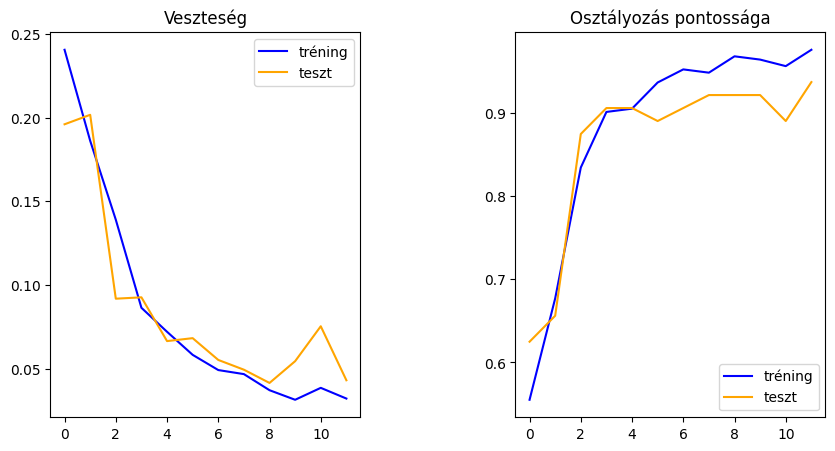

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Veszteség')
ax[0].plot(history.history['loss'], color='blue', label='tréning')
ax[0].plot(history.history['val_loss'], color='orange', label='teszt')
ax[0].legend()
# pontosság ábrázolása
ax[1].set_title('Osztályozás pontossága')
ax[1].plot(history.history['accuracy'], color='blue', label='tréning')
ax[1].plot(history.history['val_accuracy'], color='orange', label='teszt')
ax[1].legend(loc=4)
plt.subplots_adjust(wspace=0.5)

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(f"Pontosság teszt  adatokra: {np.sum(binary_accuracy(y_test, y_pred_test, threshold=0.5)[:,0]) / y_pred_test.shape[0]:.1%}")
print(f"Pontosság tanító adatokra: {np.sum(binary_accuracy(y_train, y_pred_train, threshold=0.5)[:,0]) / y_pred_train.shape[0]:.1%}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Pontosság teszt  adatokra: 92.2%
Pontosság tanító adatokra: 98.4%


Nézzük meg, melyik teszt képet sikerült illetve nem sikerült jól besorolni. Piros színnel írjuk a fel a téves besorolásokat.

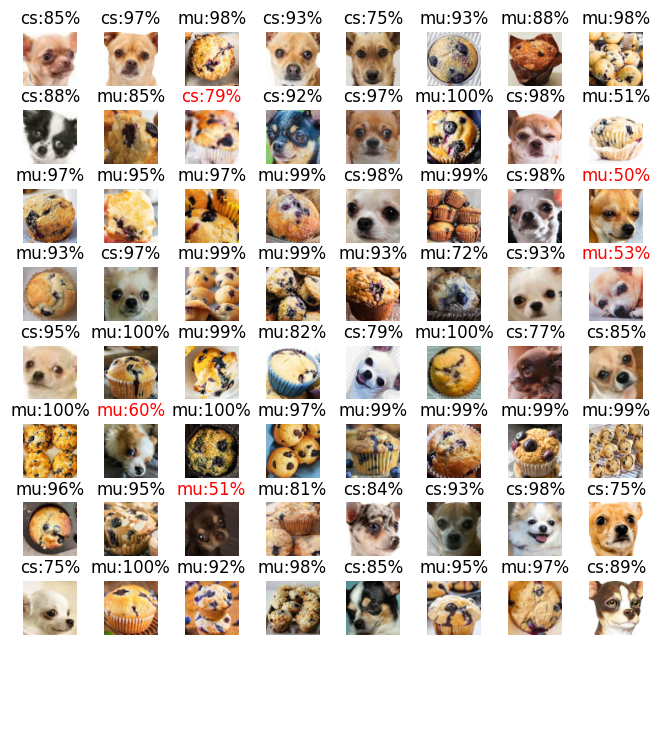

In [ ]:
pred_test_classes = np.argmax(y_pred_test, axis=1)
fig, ax = plt.subplots(X_test.shape[0]//sample_cols+1, sample_cols, figsize=(sample_cols, X_test.shape[0]//sample_cols+1))
#fig.suptitle('Teszt képek', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_test.shape[0]):
    cls = pred_test_classes[i]     # 0/1
    val = y_pred_test[i, cls]
    ax[i].imshow(X_test[i,:,:,:,0])
    color= 'black' if int(cls+0.5) == y_orig_test[i] else 'red'
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.0%}", c=color)
plt.subplots_adjust(wspace=0.5)

A képek feletti százalékos érték jelzi a besorolás valószínűségét. Az esetek döntő többségében 70% feletti a valószinűség, ennek ellenére hibás osztályozás is van.

Nézzük meg a tévesztési mátrixot és a megbízhatósági jellemzőket!

accuracy: 92.2%
precision: 90.0%
recall: 97.3%
F1 score: 93.5%


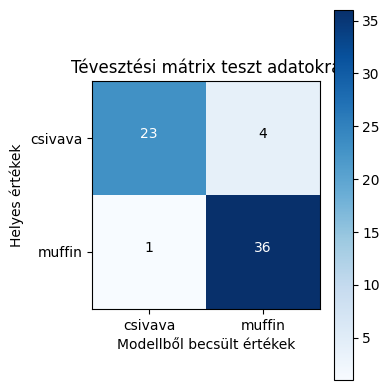

In [ ]:
cm = confusion_matrix(y_orig_test, pred_test_classes)
TN = cm[0, 0]; TP = cm[1, 1]
FP = cm[0,1]; FN = cm[1, 0]
accuracy = (TN + TP) / (TN + FP + TP + FN)  # jó döntések (valódi pozitív és valódi negatív) aránya az összes esethez
precision = TP / (TP + FP)                  # valódi pozitív döntések aranya az összes pozitív döntéshez
recall = TP / (TP + FN)
F1 = 2 * precision * recall / (precision + recall)
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Tévesztési mátrix teszt adatokra')
plt.colorbar()
thresh = cm.min() + (cm.max() - cm.min()) / 2
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# Számok hozzáadása a cellákhoz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('Helyes értékek')
        plt.xlabel('Modellből becsült értékek')
print(f"accuracy: {accuracy:.1%}\nprecision: {precision:.1%}\nrecall: {recall:.1%}\nF1 score: {F1:.1%}")

Ismételjük meg a tanítástól a folyamatot! Vegye észre, hogy a megismételt futtatás eredménye nem azonos az előzővel, mivel véletlenszámoktól is függ a tanítási folyamat.

Végül nézzük meg a modellünk teljesítményét eddig nem látott fényképeken.

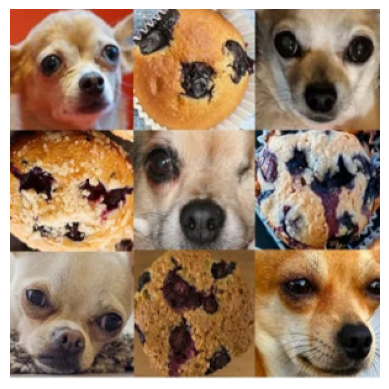

In [ ]:
!wget -q -O cs_ma_test.jpg https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/cs_ma_test.jpg?raw=true
test_rows = 3
test_cols = 3
test_num = test_cols * test_rows
imgt = imread('cs_ma_test.jpg')
plt.imshow(imgt)
_ = plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


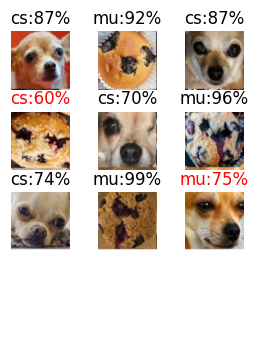

In [ ]:
# tömbök létrehozása a bemenő adatoknak
size = 100  # eredeti képméret
border = 0
XX = np.zeros((9, image_size, image_size, 3, 1), dtype='float32')
# kis képek létrehozása
k = 0
for i in range(test_rows):     # minden sorra
    pixel_top = i * size + border                             # sor felső pixele
    pixel_bot = (i + 1) * size - border                       # sor alsó pixele
    for j in range(test_cols):                              # minden oszlopra
        pixel_left = j * size + border                        # oszlop bal széle pixel
        pixel_righ = (j + 1) * size - border                  # oszlop jobb széle pixel
        sub_img = imgt[pixel_top:pixel_bot,pixel_left:pixel_righ]
        # felbontás lecsökkentése
        XX[k] = np.expand_dims(resize(sub_img, (image_size, image_size, 3)), -1)
        k += 1
# valódi cimkék
ll = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])
yy = model.predict(XX)
yy_classes = np.argmax(yy, axis=1)
fig, ax = plt.subplots(XX.shape[0]//test_cols+1, test_cols, figsize=(test_cols, XX.shape[0]//test_cols+1))
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(XX.shape[0]):
    cls = int(yy_classes[i] + 0.5)    # 0/1
    val = yy[i, cls]
    ax[i].imshow(XX[i,:,:,:,0])
    color = 'black' if cls == ll[i] else 'red'
    ax[i].set_title(f"{labels[cls][:2]}:{val:.0%}", c=color)
plt.subplots_adjust(wspace=0.5)

Piros felirattal jelöltük a téves osztályozásokat.